In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    
    # Number of GPUs available
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"\nDetails for GPU {i}:")
        print(f"Name: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {torch.cuda.get_device_properties(i).total_memory / (1024**3):.2f} GB")
        print(f"Multi-Processor Count: {torch.cuda.get_device_properties(i).multi_processor_count}")
        print(f"Compute Capability: {torch.cuda.get_device_capability(i)}")
else:
    print("CUDA is not available on this system.")

CUDA is available!
Number of GPUs available: 1

Details for GPU 0:
Name: NVIDIA A100-SXM4-80GB
Total Memory: 79.14 GB
Multi-Processor Count: 108
Compute Capability: (8, 0)


In [19]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

In [20]:
# Load your data
data = np.load('2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

In [21]:
# dropping all data with only 20 frames
data = np.array([i for i in data if i['cine_lv_myo_masks_cropped'].shape[2] != 20])

In [22]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinConfig, SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, data, desired_num_frames=25, image_size=80):
        self.inputs = []
        self.targets = []
        self.desired_num_frames = desired_num_frames
        self.image_size = image_size
        self.to_pil = transforms.ToPILImage()
        self.resize = transforms.Resize((image_size, image_size))
        self.to_tensor = transforms.ToTensor()

        for item in data:
            mask_volume = item['cine_lv_myo_masks_cropped']  # Shape: (H, W, n_frames)
            tos = item['TOS']  # Shape: (126,)
            self.inputs.append(mask_volume)
            self.targets.append(tos)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        mask_volume = self.inputs[idx]  # Shape: (H, W, n_frames)
        tos = self.targets[idx]  # Shape: (126,)

        # Rearrange mask_volume to (n_frames, H, W)
        mask_volume = mask_volume.transpose(2, 0, 1)  # Now shape is (n_frames, H, W)

        # Ensure the number of frames is desired_num_frames
        num_frames = mask_volume.shape[0]
        desired_num_frames = self.desired_num_frames
        if num_frames < desired_num_frames:
            # Pad with zeros (blank frames)
            pad_size = desired_num_frames - num_frames
            pad_frames = np.zeros((pad_size, mask_volume.shape[1], mask_volume.shape[2]), dtype=mask_volume.dtype)
            mask_volume = np.concatenate((mask_volume, pad_frames), axis=0)
        elif num_frames > desired_num_frames:
            # Sample frames evenly
            indices = np.linspace(0, num_frames - 1, desired_num_frames, dtype=int)
            mask_volume = mask_volume[indices]
        # Now mask_volume has shape (desired_num_frames, H, W)

        # Process frames and stack along the channel dimension
        frames = []
        for frame in mask_volume:
            frame = frame.astype(np.uint8)  # Convert to uint8
            frame_pil = self.to_pil(frame)
            frame_resized = self.resize(frame_pil)
            frame_tensor = self.to_tensor(frame_resized)  # Shape: (1, H, W)
            frames.append(frame_tensor.squeeze(0))  # Remove channel dimension
        # Stack frames along the channel dimension
        frames_tensor = torch.stack(frames, dim=0)  # Shape: (desired_num_frames, H, W)
        # Combine frames into a single tensor with channels
        frames_tensor = frames_tensor.unsqueeze(0)  # Shape: (1, desired_num_frames, H, W)
        frames_tensor = frames_tensor.squeeze(0)  # Final shape: (desired_num_frames, H, W)

        # Convert tos to tensor
        tos_tensor = torch.tensor(tos, dtype=torch.float32)

        return frames_tensor, tos_tensor  # frames_tensor shape: (desired_num_frames, image_size, image_size)

# Set parameters
desired_num_frames = 25  # Number of frames per sample (will be used as num_channels)
image_size = 80          # Custom image size

# Create Dataset
dataset = MyDataset(data, desired_num_frames=desired_num_frames, image_size=image_size)

# Split dataset into training and testing sets (90% train, 10% test)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the Regression Model with Custom SwinConfig
class CustomSwinRegressionModel(nn.Module):
    def __init__(self, image_size=80, num_channels=25):
        super(CustomSwinRegressionModel, self).__init__()
        # Define custom SwinConfig
        self.config = SwinConfig(
            image_size=image_size,
            patch_size=4,
            num_channels=num_channels,
            embed_dim=192,
            depths=[2, 4, 24, 4],
            num_heads=[3, 6, 12, 24],
            window_size=2,  # Adjusted window size
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.2,
        )
        self.swin = SwinModel(self.config)
        self.fc = nn.Linear(self.config.hidden_size, 126)

    def forward(self, x):
        # x: (batch_size, num_channels, image_size, image_size)
        outputs = self.swin(pixel_values=x)
        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Shape: (batch_size, hidden_size)
        regression_output = self.fc(hidden_states)  # Shape: (batch_size, 126)
        return regression_output

# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomSwinRegressionModel(image_size=image_size, num_channels=desired_num_frames).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Function to compute R^2 score
def compute_r2_score(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)  # Shape: (batch_size, num_channels, image_size, image_size)
            targets = targets.to(device)

            outputs = model(inputs)
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    mean_targets = torch.mean(all_targets, dim=0)
    total_sum_of_squares = torch.sum((all_targets - mean_targets) ** 2)
    residual_sum_of_squares = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return r2.item()

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", unit="batch")
    for batch_idx, batch in enumerate(progress_bar):
        inputs, targets = batch
        inputs = inputs.to(device)  # Shape: (batch_size, num_channels, image_size, image_size)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # outputs: (batch_size, 126)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Completed. Average Training Loss: {avg_loss:.4f}")

# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Epoch 1/100


Training Epoch 1: 100%|██████████| 101/101 [00:12<00:00,  7.78batch/s, Batch Loss=795]    


Epoch 1 Completed. Average Training Loss: 934.7971

Epoch 2/100


Training Epoch 2: 100%|██████████| 101/101 [00:12<00:00,  7.90batch/s, Batch Loss=129]   


Epoch 2 Completed. Average Training Loss: 534.6481

Epoch 3/100


Training Epoch 3: 100%|██████████| 101/101 [00:12<00:00,  8.13batch/s, Batch Loss=482]   


Epoch 3 Completed. Average Training Loss: 359.9581

Epoch 4/100


Training Epoch 4: 100%|██████████| 101/101 [00:12<00:00,  8.08batch/s, Batch Loss=187]   


Epoch 4 Completed. Average Training Loss: 284.6907

Epoch 5/100


Training Epoch 5:  41%|████      | 41/101 [00:05<00:07,  7.82batch/s, Batch Loss=513]    


KeyboardInterrupt: 

In [23]:
# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Final R^2 Score on Test Dataset: -0.0744


Plotting Training Data Predictions:


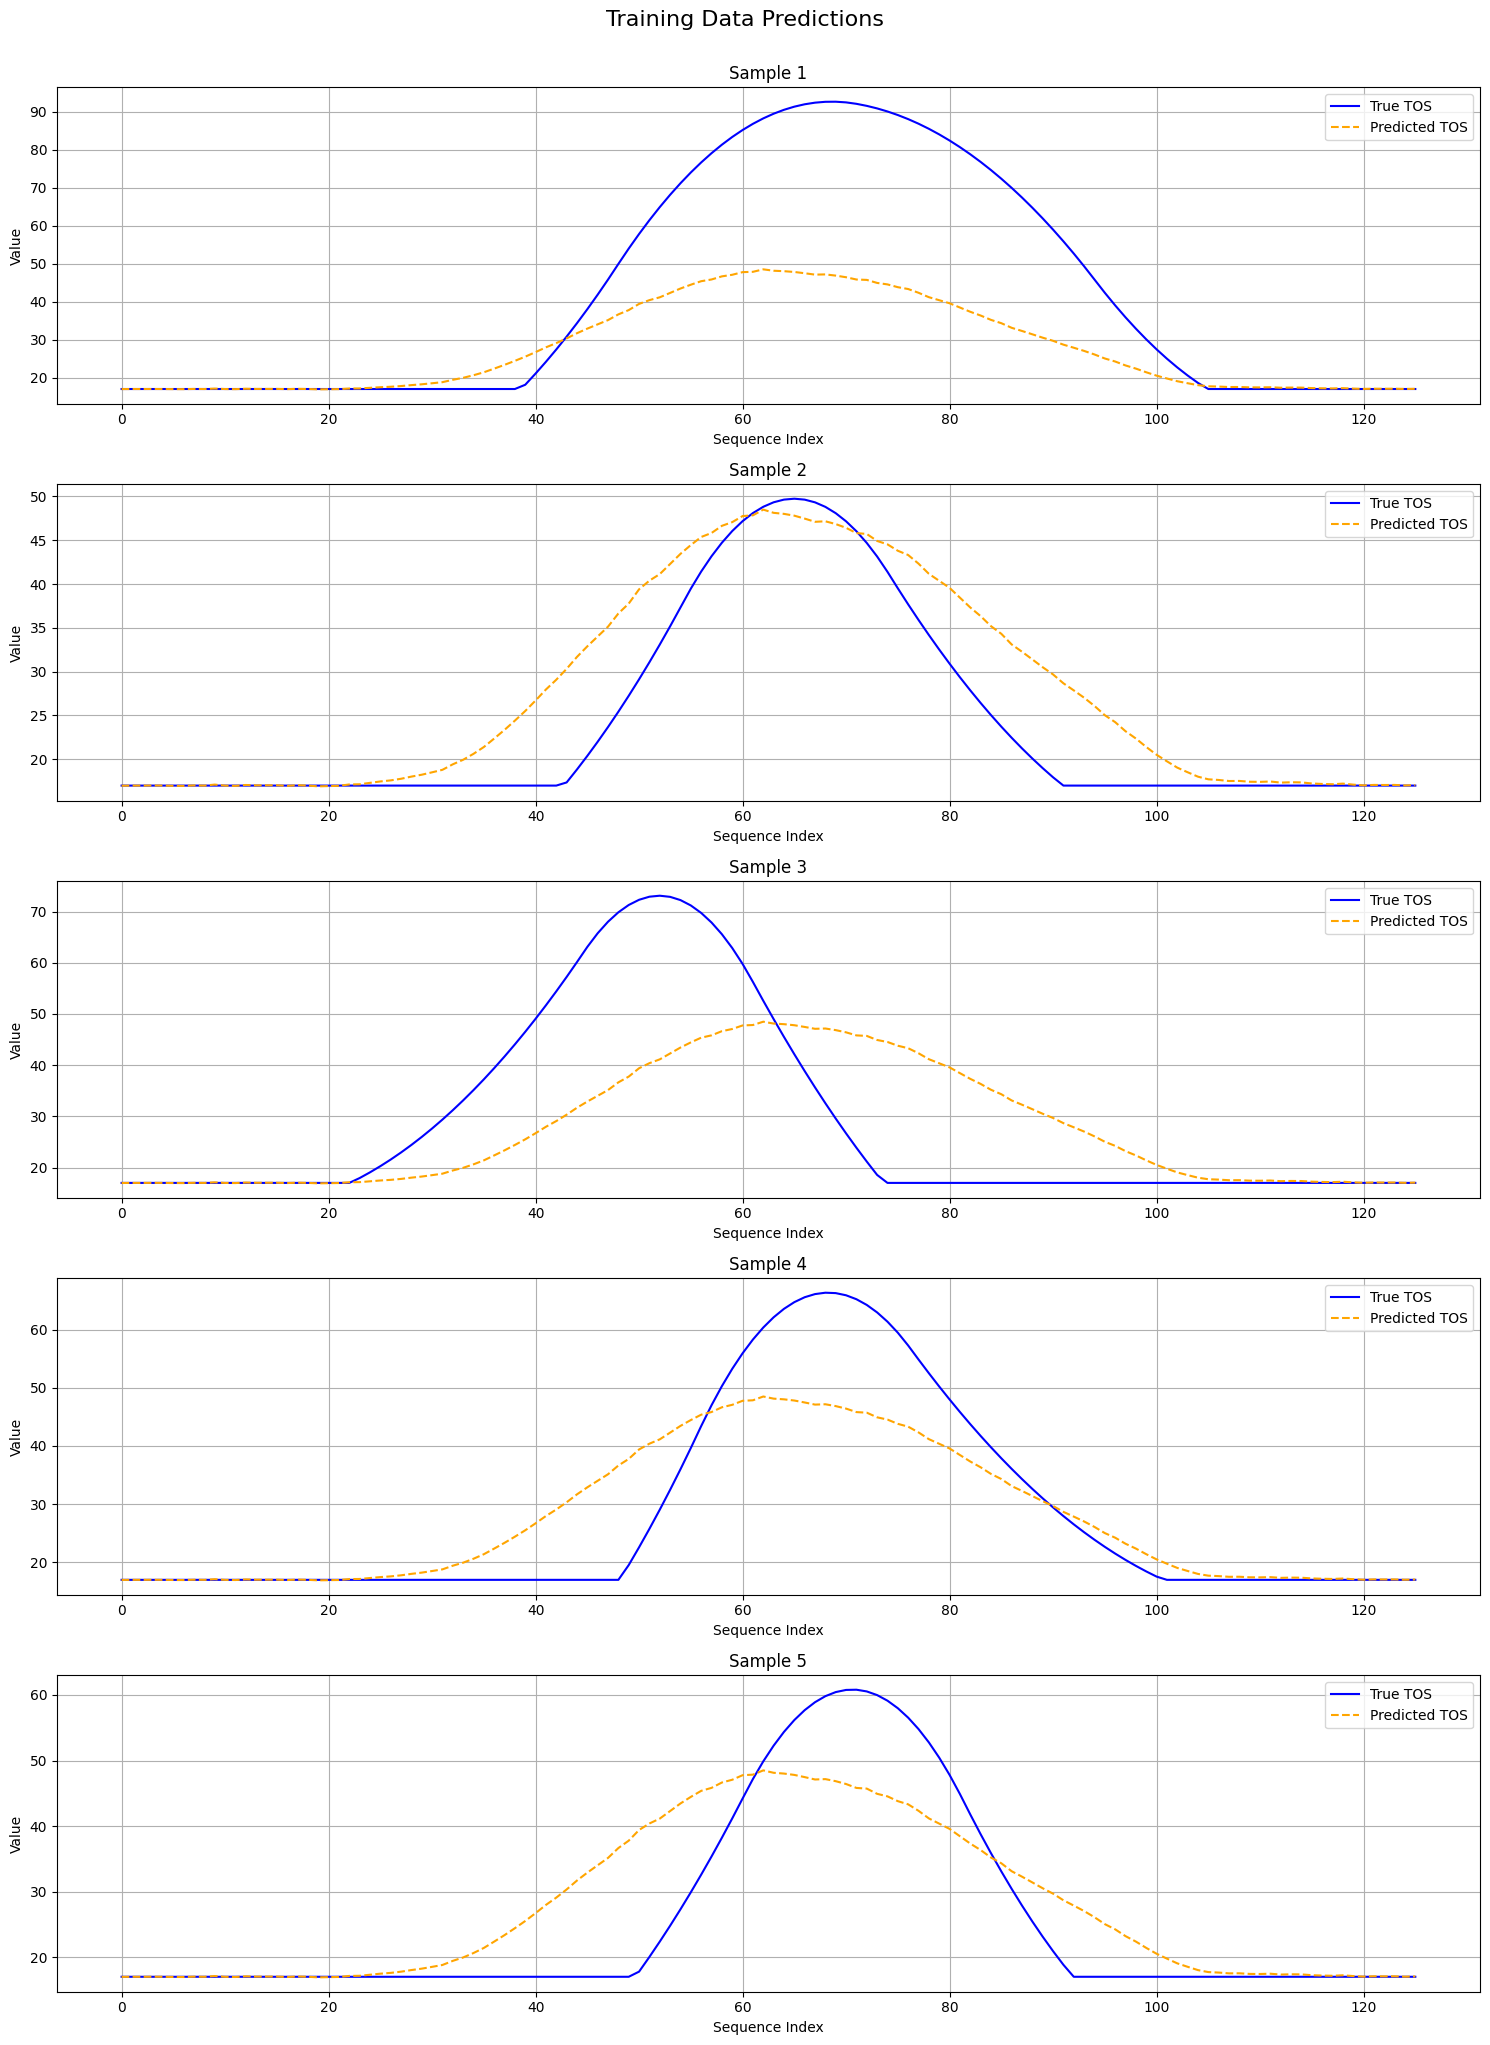

Plotting Testing Data Predictions:


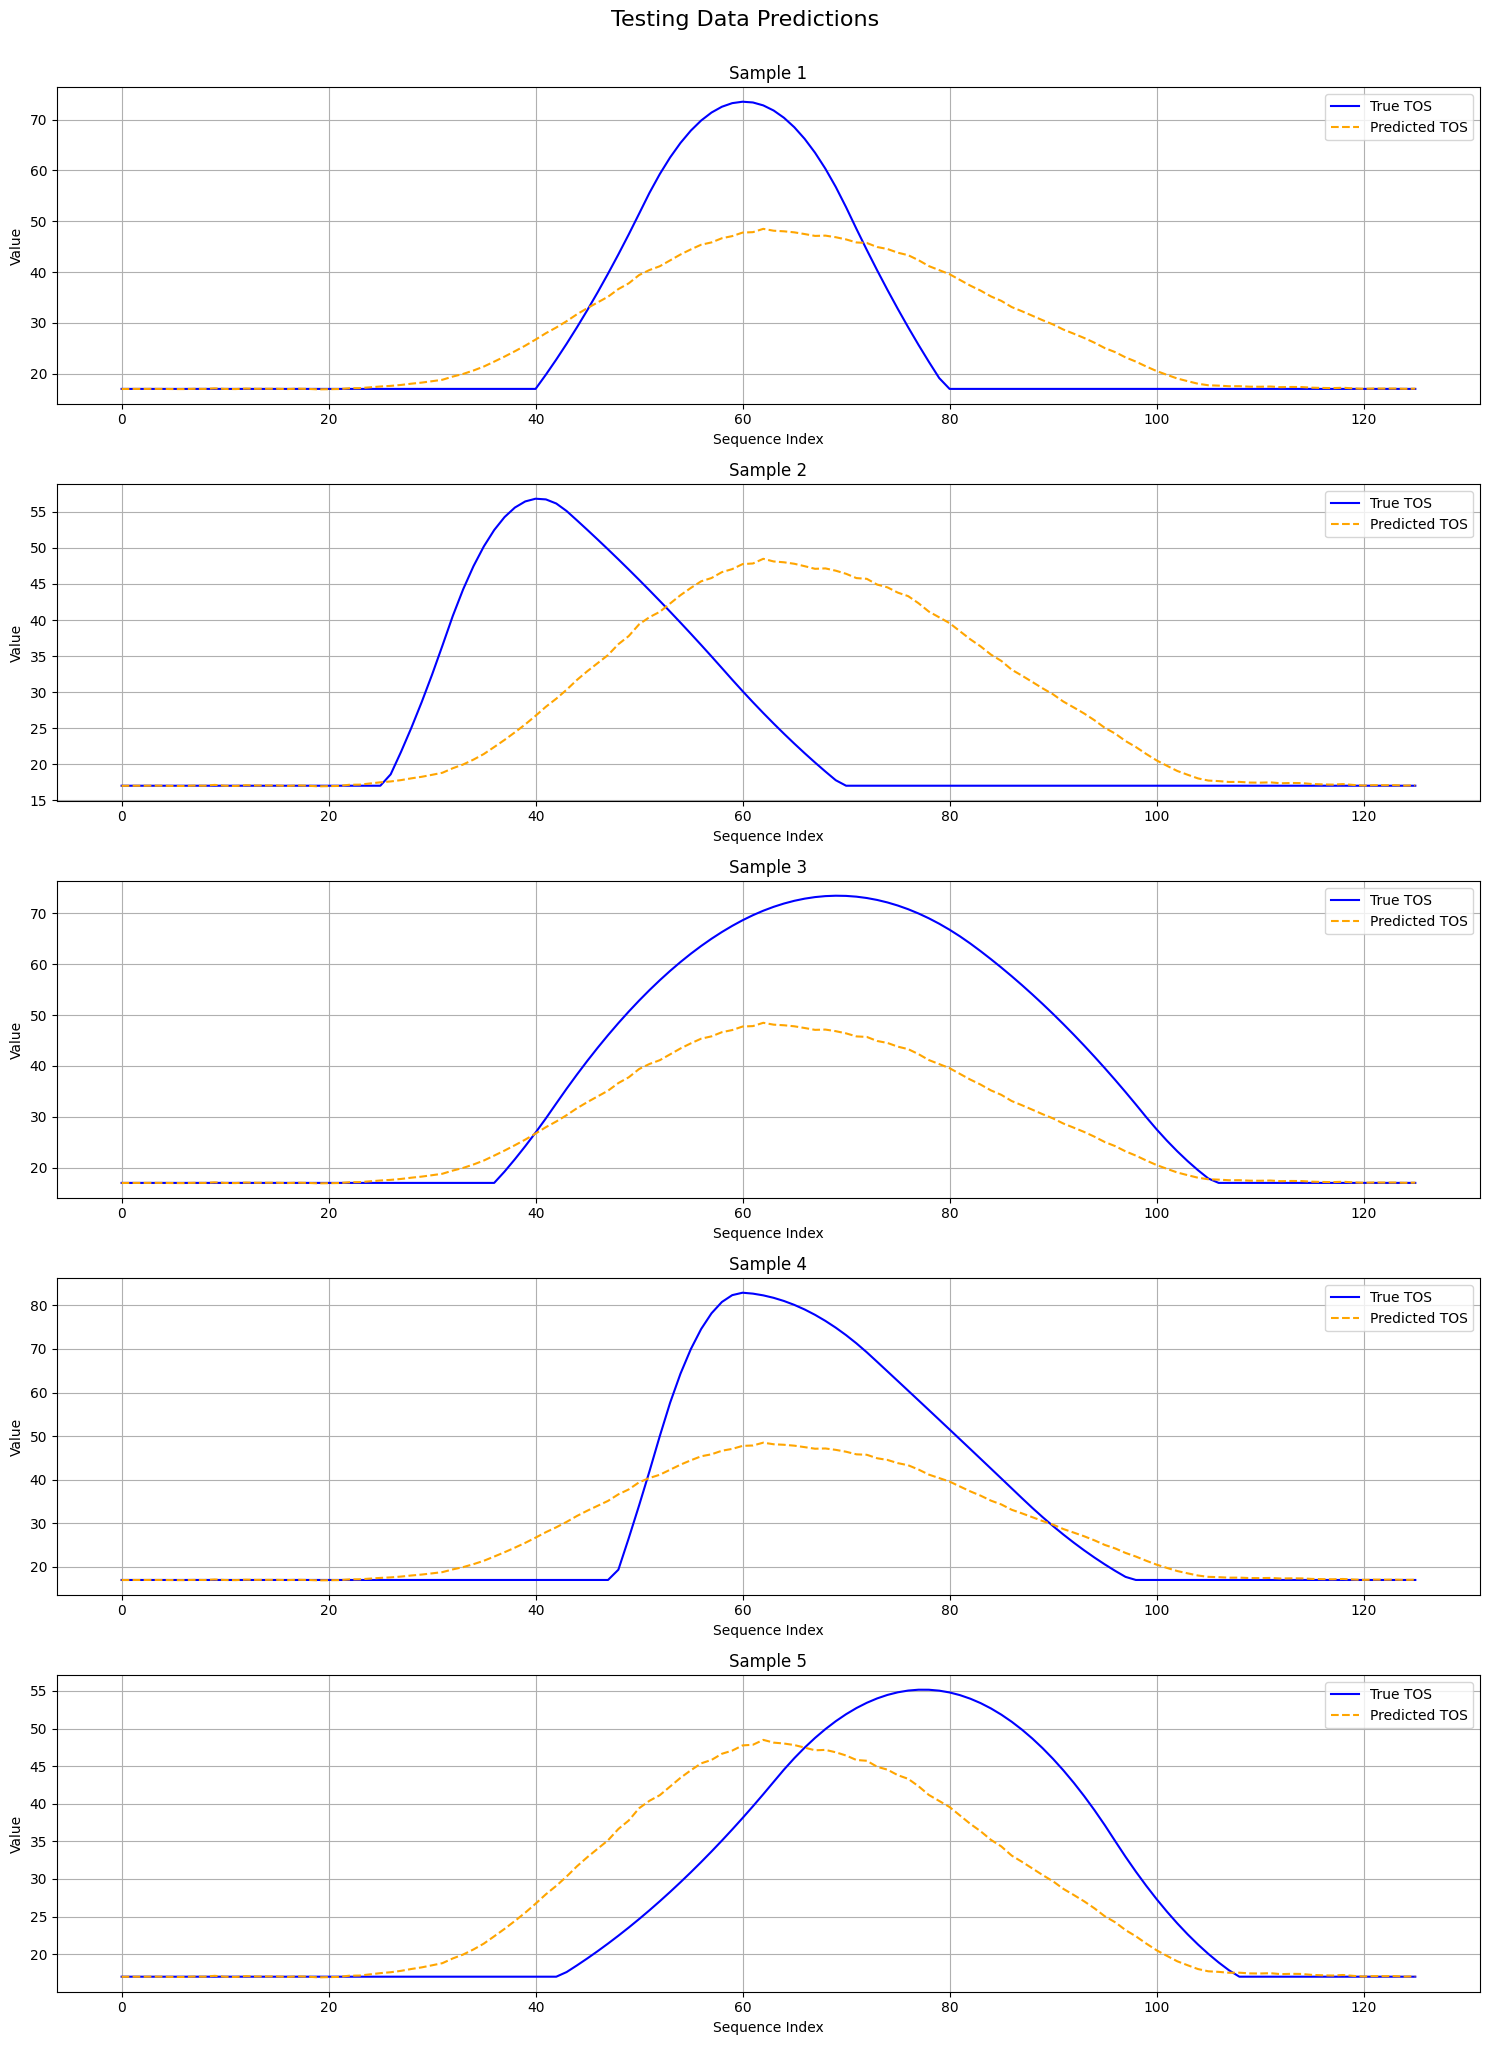

In [24]:
import matplotlib.pyplot as plt
import random

# Function to plot TOS and predictions
def plot_tos_predictions(model, dataloader, device, title="TOS Predictions", num_samples=5):
    """
    Plots true TOS and predicted TOS for a few samples from a dataloader.
    
    Args:
    - model: Trained model.
    - dataloader: DataLoader (train or test).
    - device: Device used for computation.
    - title: Title of the plot.
    - num_samples: Number of samples to plot.
    """
    model.eval()
    true_tos = []
    predicted_tos = []
    
    # Get a few samples
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predictions = model(inputs)
            
            true_tos.extend(targets.cpu().numpy())
            predicted_tos.extend(predictions.cpu().numpy())
            
            if len(true_tos) >= num_samples:
                break  # Stop after collecting the required number of samples

    # Randomly select num_samples to plot
    indices = random.sample(range(len(true_tos)), num_samples)
    true_tos = [true_tos[i] for i in indices]
    predicted_tos = [predicted_tos[i] for i in indices]
    
    # Plot each sample
    plt.figure(figsize=(15, num_samples * 4))
    for i, (true, pred) in enumerate(zip(true_tos, predicted_tos)):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(true, label="True TOS", color='blue')
        plt.plot(pred, label="Predicted TOS", color='orange', linestyle='--')
        plt.title(f"Sample {i + 1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Plotting training data
print("Plotting Training Data Predictions:")
plot_tos_predictions(model, train_dataloader, device, title="Training Data Predictions", num_samples=5)

# Plotting testing data
print("Plotting Testing Data Predictions:")
plot_tos_predictions(model, test_dataloader, device, title="Testing Data Predictions", num_samples=5)

In [25]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinConfig, SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, data, desired_num_frames=25, image_size=80):
        self.inputs = []
        self.targets = []
        self.desired_num_frames = desired_num_frames
        self.frame_image_size = image_size  # Size of individual frames
        self.to_pil = transforms.ToPILImage()
        self.resize = transforms.Resize((image_size, image_size))
        self.to_tensor = transforms.ToTensor()

        for item in data:
            mask_volume = item['cine_lv_myo_masks_cropped']  # Shape: (H, W, n_frames)
            tos = item['TOS']  # Shape: (126,)
            self.inputs.append(mask_volume)
            self.targets.append(tos)

        # Calculate grid size for concatenating frames
        self.grid_size = int(np.ceil(np.sqrt(self.desired_num_frames)))
        self.total_frames = self.grid_size ** 2  # Total frames in the grid
        self.concat_image_size = self.grid_size * self.frame_image_size  # Size of the concatenated image

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        mask_volume = self.inputs[idx]  # Shape: (H, W, n_frames)
        tos = self.targets[idx]  # Shape: (126,)

        # Rearrange mask_volume to (n_frames, H, W)
        mask_volume = mask_volume.transpose(2, 0, 1)  # Now shape is (n_frames, H, W)

        # Ensure the number of frames is total_frames (to fill the grid)
        num_frames = mask_volume.shape[0]
        total_frames = self.total_frames
        if num_frames < total_frames:
            # Pad with zeros (blank frames)
            pad_size = total_frames - num_frames
            pad_frames = np.zeros((pad_size, mask_volume.shape[1], mask_volume.shape[2]), dtype=mask_volume.dtype)
            mask_volume = np.concatenate((mask_volume, pad_frames), axis=0)
        elif num_frames > total_frames:
            # Sample frames evenly
            indices = np.linspace(0, num_frames - 1, total_frames, dtype=int)
            mask_volume = mask_volume[indices]
        # Now mask_volume has shape (total_frames, H, W)

        # Process frames
        frames = []
        for frame in mask_volume:
            frame = frame.astype(np.uint8)  # Convert to uint8
            frame_pil = self.to_pil(frame)
            frame_resized = self.resize(frame_pil)
            frame_tensor = self.to_tensor(frame_resized)  # Shape: (1, H, W)
            frames.append(frame_tensor)

        # Stack frames to create a tensor of shape (total_frames, C=1, H, W)
        frames_tensor = torch.stack(frames)  # Shape: (total_frames, 1, H, W)

        # Arrange frames into a grid
        frames_tensor = frames_tensor.view(self.grid_size, self.grid_size, 1, self.frame_image_size, self.frame_image_size)
        # Shape: (grid_size, grid_size, C=1, H, W)

        # Concatenate frames to form a grid image
        rows = []
        for i in range(self.grid_size):
            # Concatenate frames in the row along the width (dim=2)
            row = torch.cat([frames_tensor[i, j] for j in range(self.grid_size)], dim=2)
            # row shape: (C=1, H, grid_size * W)
            rows.append(row)

        # Concatenate rows along the height (dim=1)
        image = torch.cat(rows, dim=1)
        # image shape: (C=1, grid_size * H, grid_size * W)

        # Convert tos to tensor
        tos_tensor = torch.tensor(tos, dtype=torch.float32)

        return image, tos_tensor  # image shape: (C=1, H_total, W_total)

# Set parameters
desired_num_frames = 25  # Number of frames per sample (to be arranged in grid)
frame_image_size = 80    # Size of individual frame
grid_size = int(np.ceil(np.sqrt(desired_num_frames)))
concat_image_size = frame_image_size * grid_size  # Size of concatenated image

# Create Dataset
dataset = MyDataset(data, desired_num_frames=desired_num_frames, image_size=frame_image_size)

# Split dataset into training and testing sets (90% train, 10% test)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the Regression Model with Custom SwinConfig
class CustomSwinRegressionModel(nn.Module):
    def __init__(self, image_size, num_channels=1):
        super(CustomSwinRegressionModel, self).__init__()
        # Define custom SwinConfig
        self.config = SwinConfig(
            image_size=image_size,  # Image size as a tuple (H, W)
            patch_size=4,
            num_channels=num_channels,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=5,  # Adjusted window size
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.2,
        )
        self.swin = SwinModel(self.config)
        self.fc = nn.Linear(self.config.hidden_size, 126)

    def forward(self, x):
        # x: (batch_size, num_channels=1, H_total, W_total)
        outputs = self.swin(pixel_values=x)
        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Shape: (batch_size, hidden_size)
        regression_output = self.fc(hidden_states)  # Shape: (batch_size, 126)
        return regression_output

# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomSwinRegressionModel(image_size=(concat_image_size, concat_image_size), num_channels=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Function to compute R^2 score
def compute_r2_score(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)  # Shape: (batch_size, num_channels=1, H_total, W_total)
            targets = targets.to(device)

            outputs = model(inputs)
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    mean_targets = torch.mean(all_targets, dim=0)
    total_sum_of_squares = torch.sum((all_targets - mean_targets) ** 2)
    residual_sum_of_squares = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return r2.item()

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", unit="batch")
    for batch_idx, batch in enumerate(progress_bar):
        inputs, targets = batch
        inputs = inputs.to(device)  # Shape: (batch_size, num_channels=1, H_total, W_total)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # outputs: (batch_size, 126)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Completed. Average Training Loss: {avg_loss:.4f}")

# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Epoch 1/100


Training Epoch 1: 100%|██████████| 101/101 [00:04<00:00, 21.16batch/s, Batch Loss=344]   


Epoch 1 Completed. Average Training Loss: 1038.8335

Epoch 2/100


Training Epoch 2: 100%|██████████| 101/101 [00:04<00:00, 21.87batch/s, Batch Loss=689]   


Epoch 2 Completed. Average Training Loss: 739.5127

Epoch 3/100


Training Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 21.62batch/s, Batch Loss=284]   


Epoch 3 Completed. Average Training Loss: 544.6783

Epoch 4/100


Training Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 21.60batch/s, Batch Loss=168]   


Epoch 4 Completed. Average Training Loss: 422.8832

Epoch 5/100


Training Epoch 5: 100%|██████████| 101/101 [00:04<00:00, 20.93batch/s, Batch Loss=571]   


Epoch 5 Completed. Average Training Loss: 344.6549

Epoch 6/100


Training Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 21.00batch/s, Batch Loss=137]   


Epoch 6 Completed. Average Training Loss: 294.9890

Epoch 7/100


Training Epoch 7: 100%|██████████| 101/101 [00:05<00:00, 20.01batch/s, Batch Loss=105]   


Epoch 7 Completed. Average Training Loss: 263.9596

Epoch 8/100


Training Epoch 8: 100%|██████████| 101/101 [00:05<00:00, 19.82batch/s, Batch Loss=58.6]  


Epoch 8 Completed. Average Training Loss: 245.8486

Epoch 9/100


Training Epoch 9: 100%|██████████| 101/101 [00:04<00:00, 21.81batch/s, Batch Loss=72.6]  


Epoch 9 Completed. Average Training Loss: 235.7322

Epoch 10/100


Training Epoch 10: 100%|██████████| 101/101 [00:04<00:00, 21.12batch/s, Batch Loss=258]   


Epoch 10 Completed. Average Training Loss: 230.1155

Epoch 11/100


Training Epoch 11: 100%|██████████| 101/101 [00:05<00:00, 20.12batch/s, Batch Loss=274]  


Epoch 11 Completed. Average Training Loss: 227.1020

Epoch 12/100


Training Epoch 12: 100%|██████████| 101/101 [00:04<00:00, 21.11batch/s, Batch Loss=450]   


Epoch 12 Completed. Average Training Loss: 224.4782

Epoch 13/100


Training Epoch 13: 100%|██████████| 101/101 [00:04<00:00, 22.93batch/s, Batch Loss=26.5]  


Epoch 13 Completed. Average Training Loss: 223.1124

Epoch 14/100


Training Epoch 14: 100%|██████████| 101/101 [00:04<00:00, 20.61batch/s, Batch Loss=369]  


Epoch 14 Completed. Average Training Loss: 223.7590

Epoch 15/100


Training Epoch 15: 100%|██████████| 101/101 [00:04<00:00, 22.24batch/s, Batch Loss=515]   


Epoch 15 Completed. Average Training Loss: 222.6289

Epoch 16/100


Training Epoch 16: 100%|██████████| 101/101 [00:04<00:00, 21.12batch/s, Batch Loss=231]   


Epoch 16 Completed. Average Training Loss: 222.8869

Epoch 17/100


Training Epoch 17:  52%|█████▏    | 53/101 [00:02<00:02, 19.66batch/s, Batch Loss=152] 


KeyboardInterrupt: 

In [26]:
# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Final R^2 Score on Test Dataset: -0.0571


Plotting Training Data Predictions:


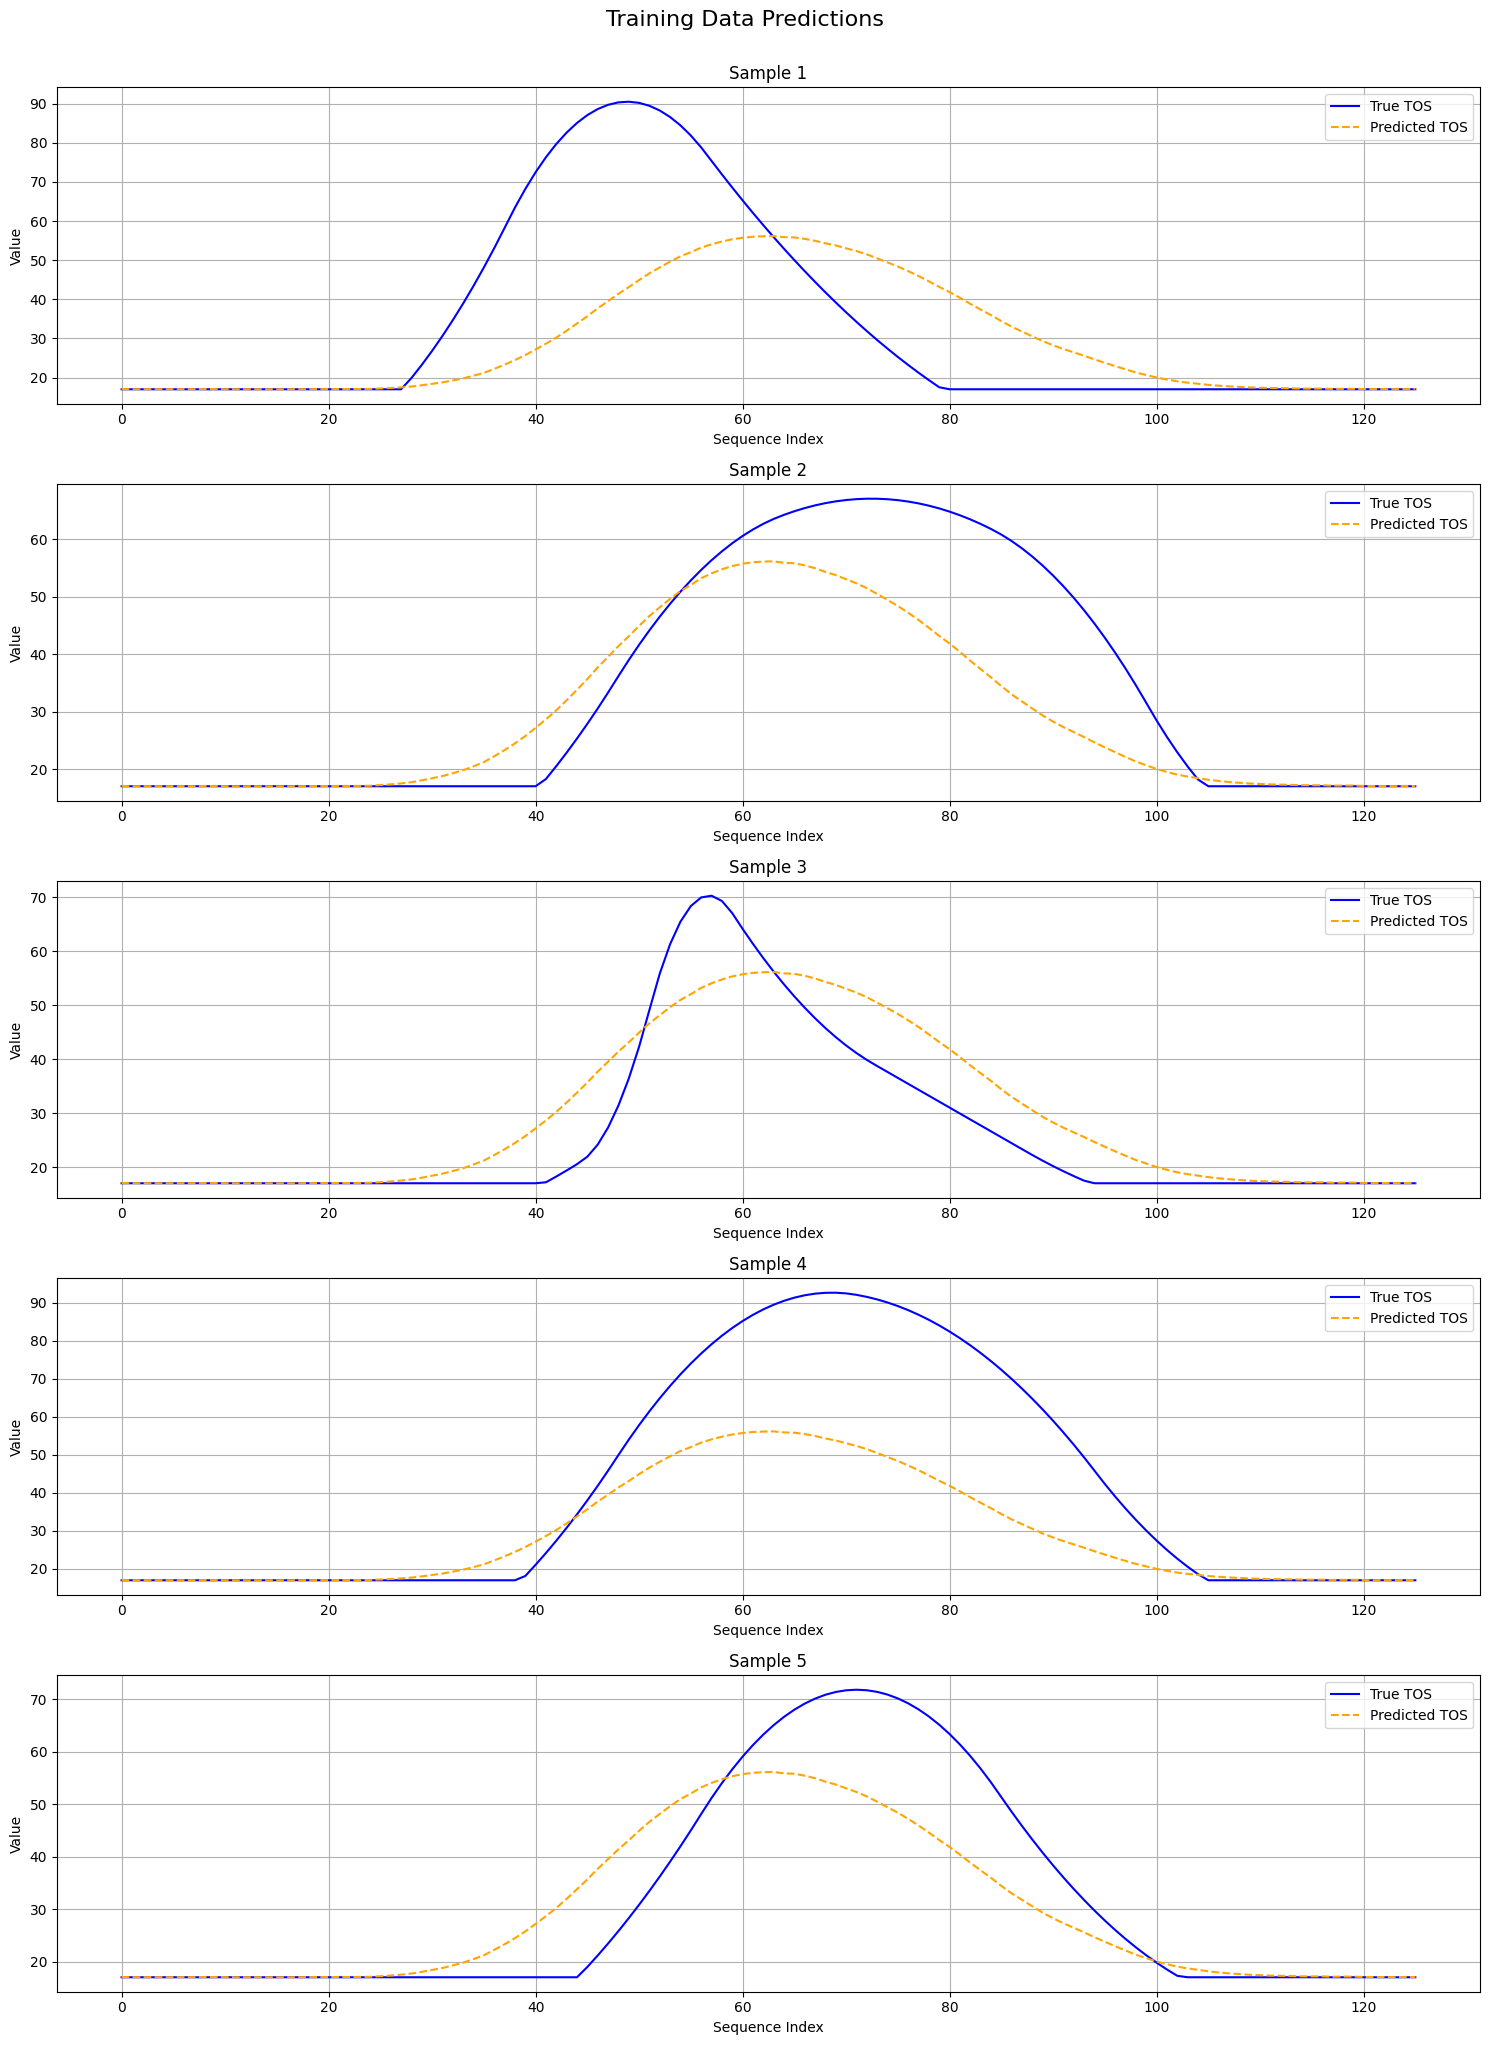

Plotting Testing Data Predictions:


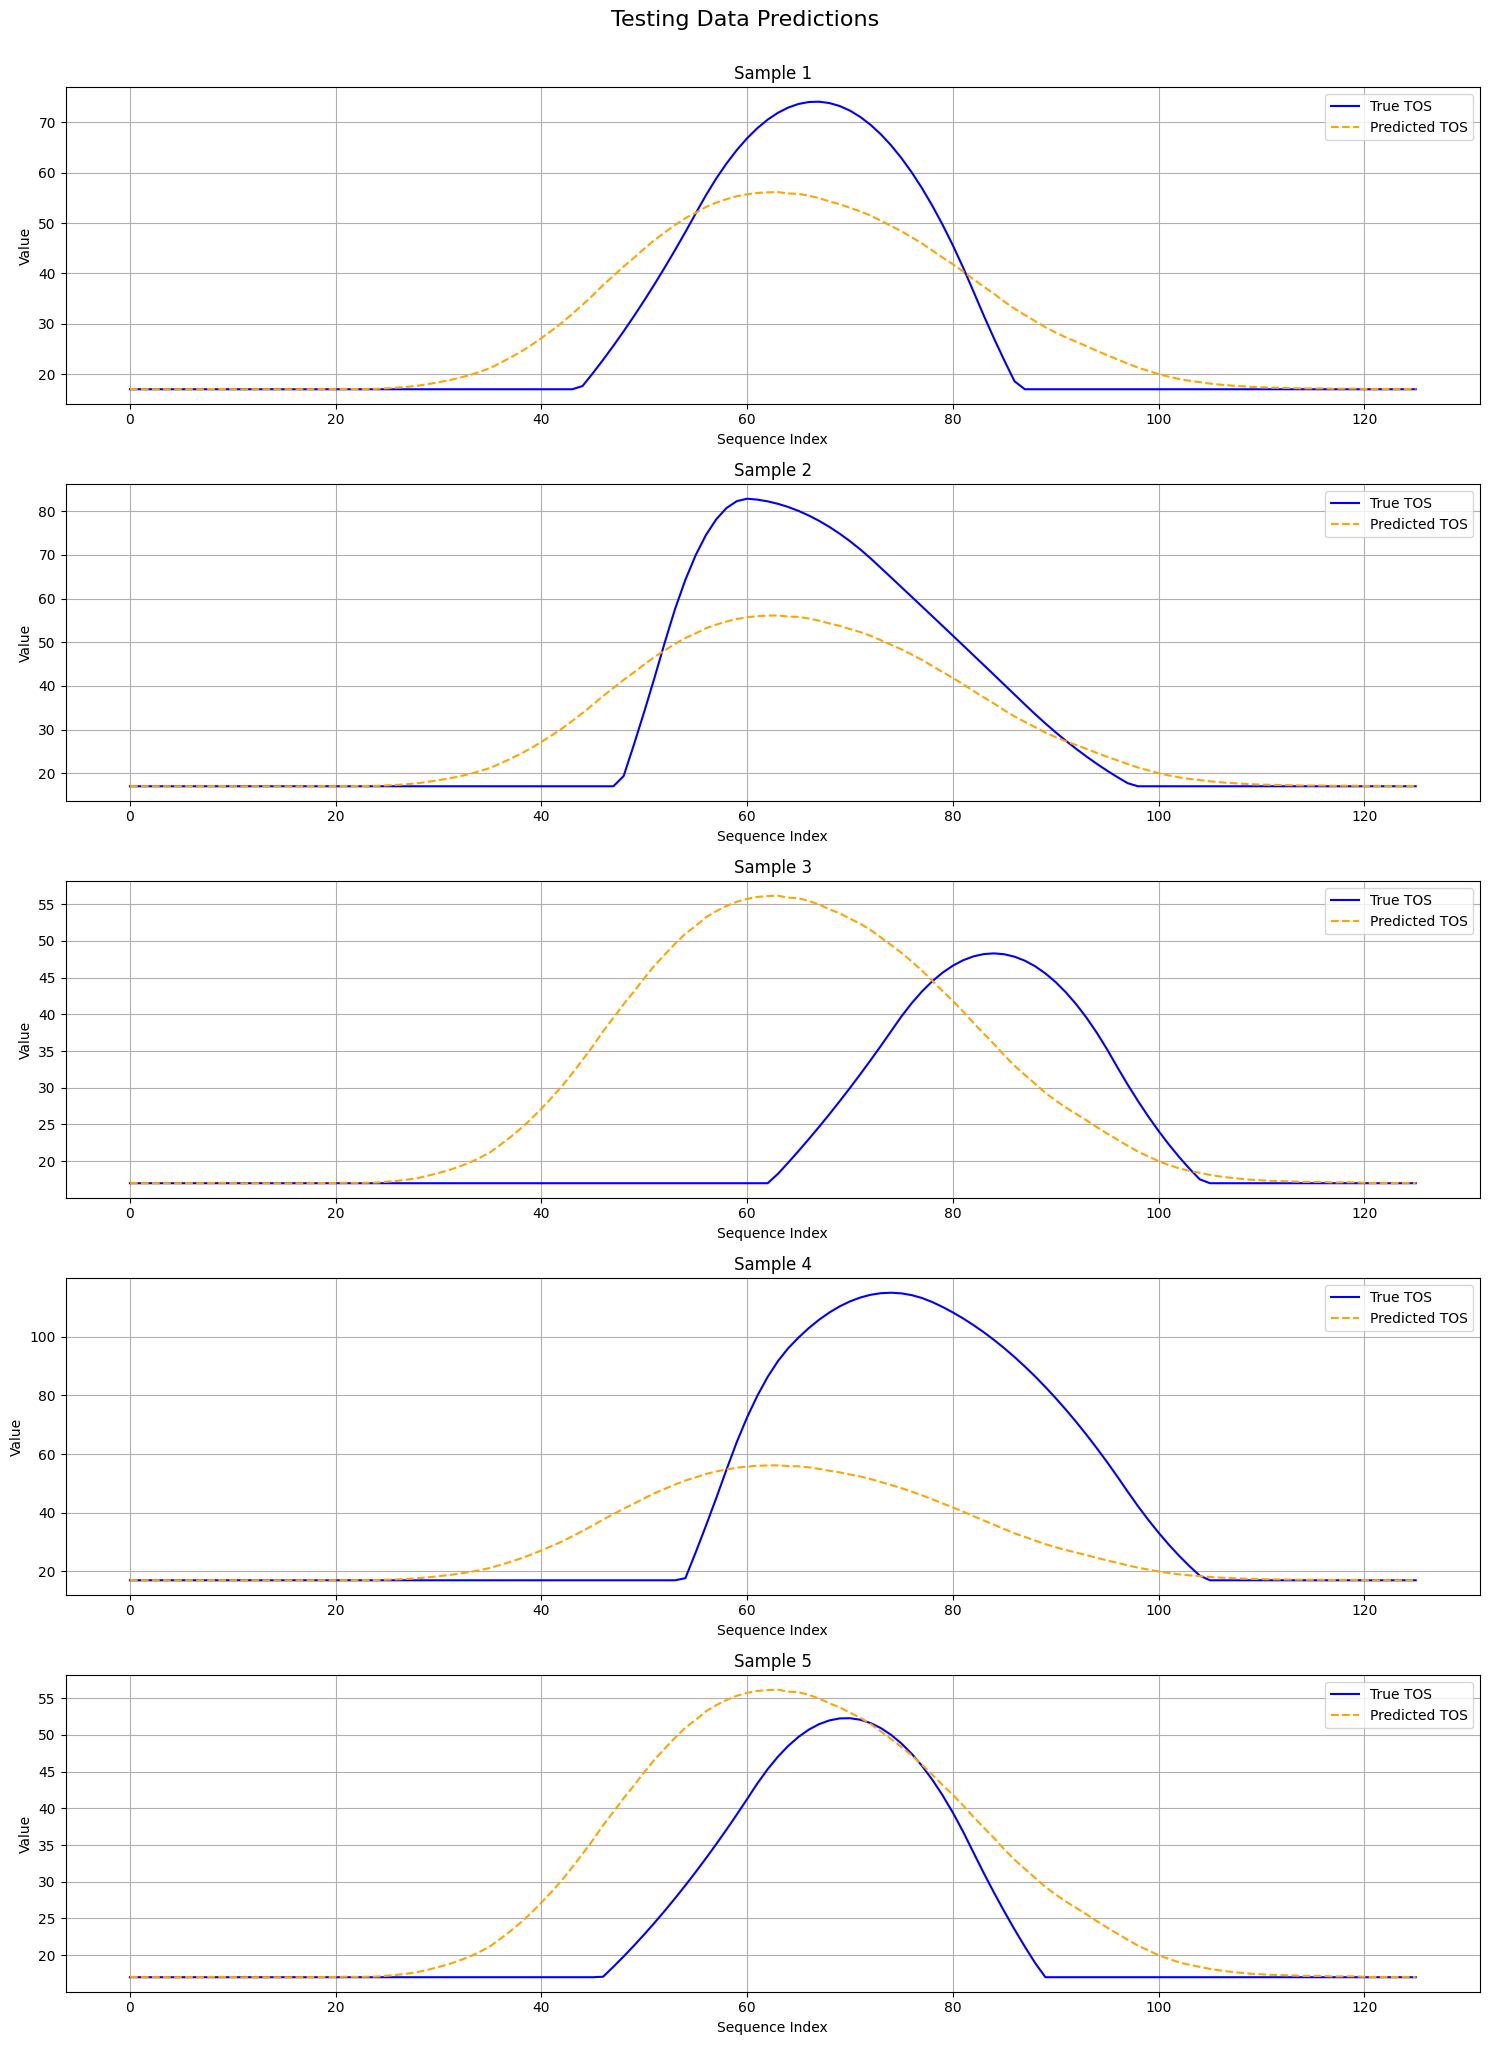

In [27]:
import matplotlib.pyplot as plt
import random

# Function to plot TOS and predictions
def plot_tos_predictions(model, dataloader, device, title="TOS Predictions", num_samples=5):
    """
    Plots true TOS and predicted TOS for a few samples from a dataloader.
    
    Args:
    - model: Trained model.
    - dataloader: DataLoader (train or test).
    - device: Device used for computation.
    - title: Title of the plot.
    - num_samples: Number of samples to plot.
    """
    model.eval()
    true_tos = []
    predicted_tos = []
    
    # Get a few samples
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predictions = model(inputs)
            
            true_tos.extend(targets.cpu().numpy())
            predicted_tos.extend(predictions.cpu().numpy())
            
            if len(true_tos) >= num_samples:
                break  # Stop after collecting the required number of samples

    # Randomly select num_samples to plot
    indices = random.sample(range(len(true_tos)), num_samples)
    true_tos = [true_tos[i] for i in indices]
    predicted_tos = [predicted_tos[i] for i in indices]
    
    # Plot each sample
    plt.figure(figsize=(15, num_samples * 4))
    for i, (true, pred) in enumerate(zip(true_tos, predicted_tos)):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(true, label="True TOS", color='blue')
        plt.plot(pred, label="Predicted TOS", color='orange', linestyle='--')
        plt.title(f"Sample {i + 1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Plotting training data
print("Plotting Training Data Predictions:")
plot_tos_predictions(model, train_dataloader, device, title="Training Data Predictions", num_samples=5)

# Plotting testing data
print("Plotting Testing Data Predictions:")
plot_tos_predictions(model, test_dataloader, device, title="Testing Data Predictions", num_samples=5)